Proyek Analisis

In [1]:
!pip install folium geopy

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import time
from pandas import ExcelFile
import ipywidgets as widgets
from IPython.display import display

Data Wrangling

Gathering Data

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sales_df = pd.read_csv('/content/drive/MyDrive/dasetssim/carSales.csv', delimiter=';')
sales_df.head()

,Car_id,Date,Customer_Name,Gender,Annual_Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price,Dealer_No,Body_Style,Phone,Dealer_Region
0,C_CND_000001,01/02/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Double Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,01/02/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,Double Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,01/02/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,01/02/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,01/02/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,Double Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


Asessing Data

Menilai Tabel sales_df

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer_Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual_Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price          23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body_Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


In [6]:
sales_df.isna().sum()

,0
Car_id,0
Date,0
Customer_Name,1
Gender,0
Annual_Income,0
Dealer_Name,0
Company,0
Model,0
Engine,0
Transmission,0


Cleaning Data

In [7]:
sales_df[sales_df.Customer_Name.isna()]

,Car_id,Date,Customer_Name,Gender,Annual_Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price,Dealer_No,Body_Style,Phone,Dealer_Region
7564,C_CND_007565,11/05/2022,NaN,Male,680000,Saab-Belle Dodge,Dodge,Ram Pickup,Double Overhead Camshaft,Auto,Pale White,45000,60504-7114,Hardtop,7203103,Aurora


In [8]:
sales_df.fillna(value="John Doe", inplace=True)

In [9]:
sales_df.isna().sum()

,0
Car_id,0
Date,0
Customer_Name,0
Gender,0
Annual_Income,0
Dealer_Name,0
Company,0
Model,0
Engine,0
Transmission,0


In [10]:
sales_df.Customer_Name.value_counts()

,count
Customer_Name,
Thomas,92
Emma,90
Lucas,88
Nathan,80
Louis,76
...,...
Bouzeau Flavie,1
Luigi,1
Maxent,1


## EDA

1. Data ini berasal dari negara mana?

In [11]:
regions = sales_df['Dealer_Region'].dropna().unique()

geolocator = Nominatim(user_agent="dealer_locator")

locations = []
for region in regions:
    try:
        location = geolocator.geocode(region + ", USA")
        if location:
            locations.append({
                'region': region,
                'lat': location.latitude,
                'lon': location.longitude
            })
        time.sleep(1)
    except:
        continue

map_dealers = folium.Map(location=[39.5, -98.35], zoom_start=4)

for loc in locations:
    folium.Marker(
        location=[loc['lat'], loc['lon']],
        popup=loc['region'],
        icon=folium.Icon(color='blue', icon='car', prefix='fa')
    ).add_to(map_dealers)

map_dealers

2. Brand apa yang menjadi pesaing terberat di negara ini berdasarkan penjualan?

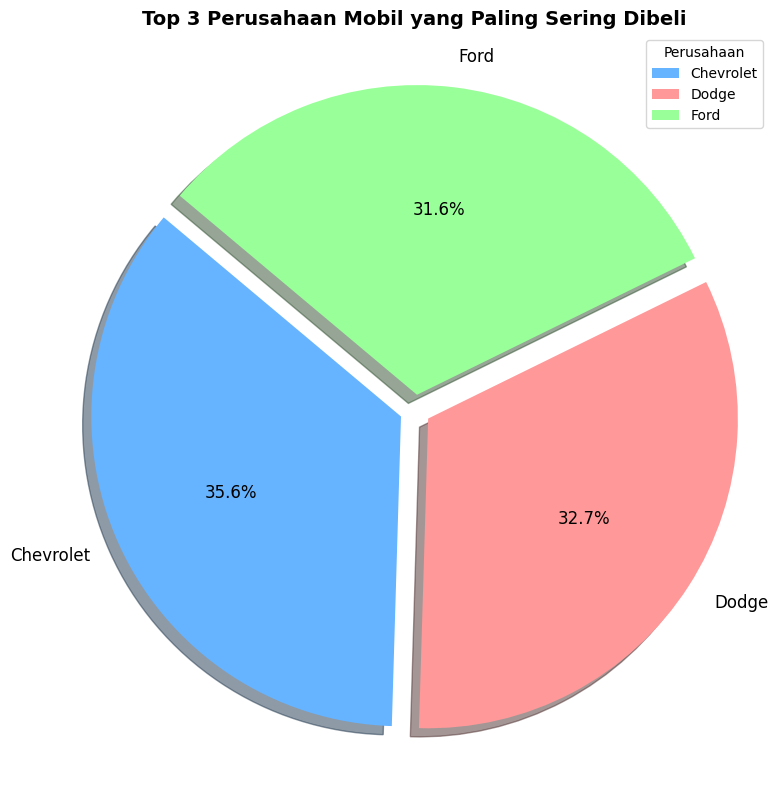

In [12]:
company_counts = sales_df['Company'].value_counts()

top3_companies = company_counts.nlargest(3)

colors = ['#66b3ff', '#ff9999', '#99ff99']

explode = (0.05, 0.05, 0.05)

plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    top3_companies,
    labels=top3_companies.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'color': 'black'}
)

plt.title('Top 3 Perusahaan Mobil yang Paling Sering Dibeli', fontsize=14, fontweight='bold')
plt.legend(patches, top3_companies.index, title="Perusahaan", loc="upper right", bbox_to_anchor=(1, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()

3. Apa 5 brand terbesar yang menguasai pasar di masing masing wilayah?

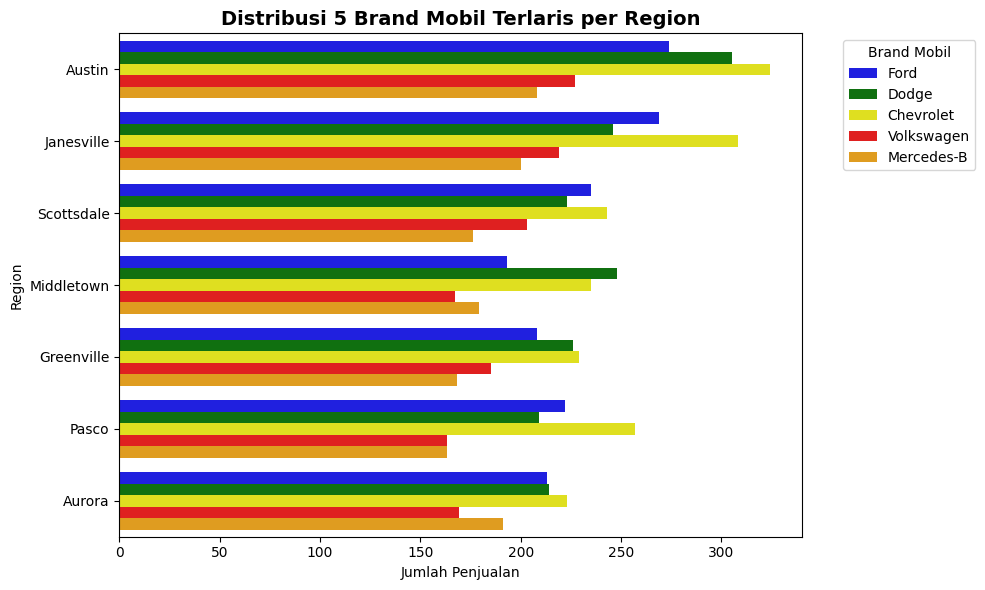

In [13]:
top5_brands = sales_df['Company'].value_counts().nlargest(5).index.tolist()

top5_df = sales_df[sales_df['Company'].isin(top5_brands)]

ordered_colors = ['blue', 'green', 'yellow', 'red', 'orange']

plt.figure(figsize=(10, 6))
sns.countplot(
    data=top5_df,
    y='Dealer_Region',
    hue='Company',
    order=top5_df['Dealer_Region'].value_counts().index,
    palette=ordered_colors
)

plt.title('Distribusi 5 Brand Mobil Terlaris per Region', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Region')
plt.legend(title='Brand Mobil', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


4. Apa tipe gaya body yang paling banyak terjual di masing masing wilayah?

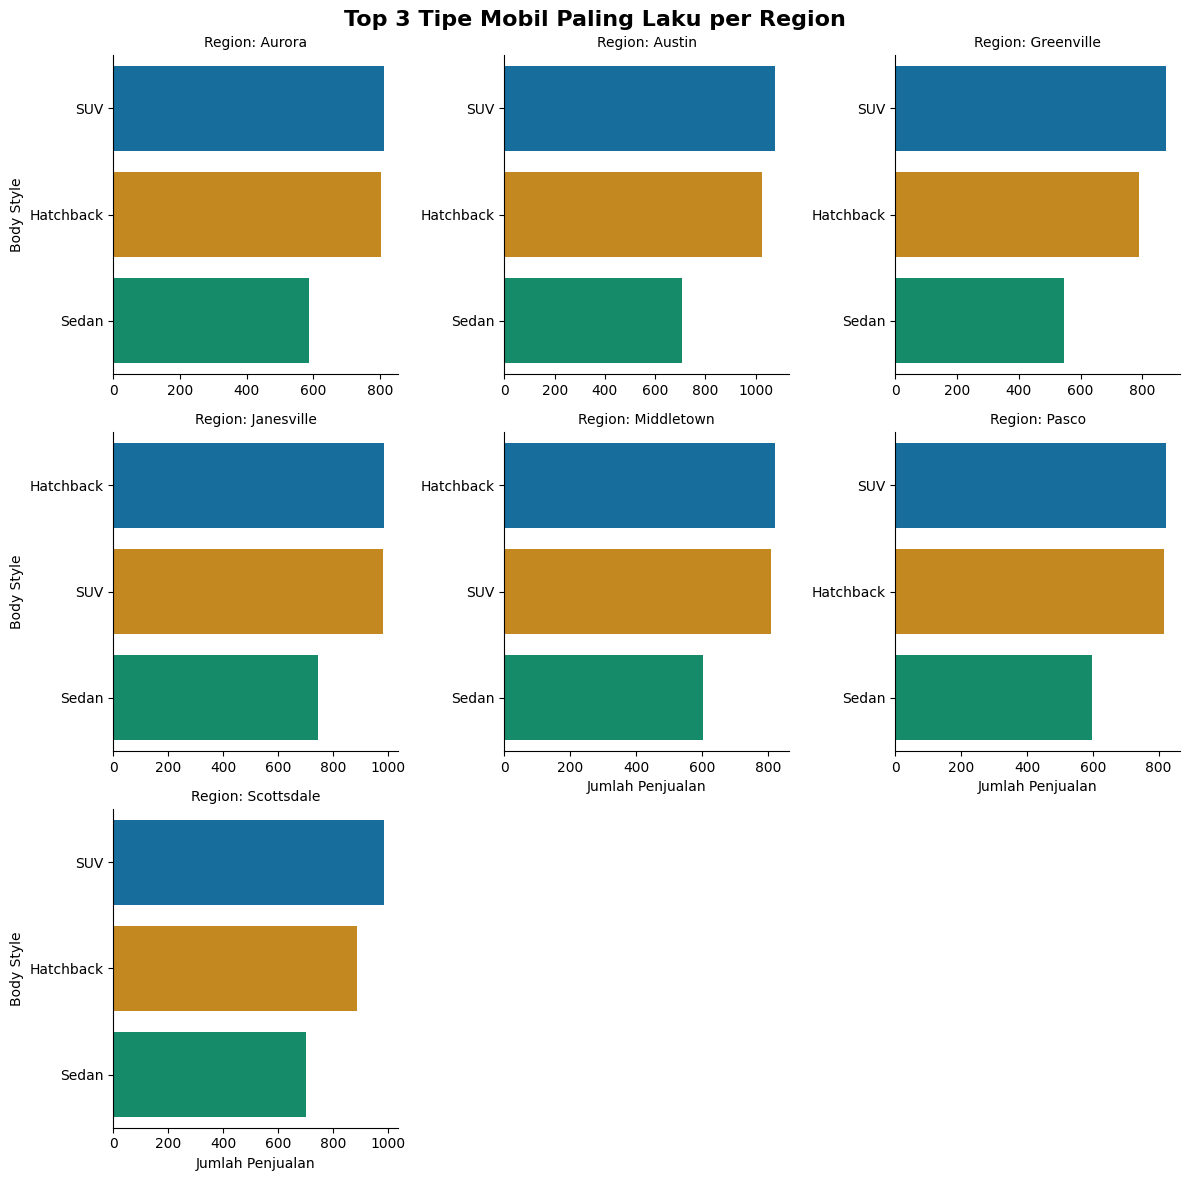

In [14]:
# Hitung jumlah penjualan tiap body style per region
region_body_counts = sales_df.groupby(['Dealer_Region', 'Body_Style']).size().reset_index(name='Count')

# Ambil top 3 body style untuk setiap region
top3_per_region = (
    region_body_counts
    .sort_values(['Dealer_Region', 'Count'], ascending=[True, False])
    .groupby('Dealer_Region')
    .head(3)
)

# Visualisasikan dengan FacetGrid
g = sns.FacetGrid(top3_per_region, col='Dealer_Region', col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.barplot, x='Count', y='Body_Style', hue='Body_Style', palette='colorblind', dodge=False)

g.set_titles(col_template="Region: {col_name}")
g.set_axis_labels("Jumlah Penjualan", "Body Style")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top 3 Tipe Mobil Paling Laku per Region', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


5. Berapa harga rata - rata setiap perusahaan di masing masing wilayah?

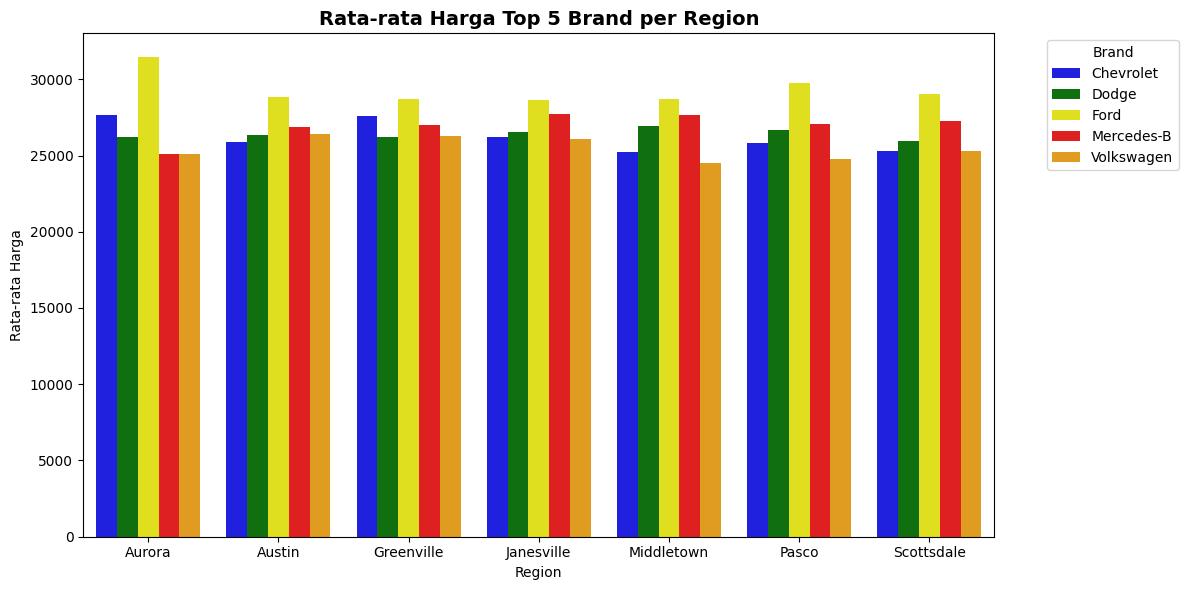

In [15]:
top5_brands = sales_df['Company'].value_counts().nlargest(5).index.tolist()

top5_df = sales_df[sales_df['Company'].isin(top5_brands)]

avg_price = top5_df.groupby(['Dealer_Region', 'Company'])['Price'].mean().reset_index()

ordered_colors = ['blue', 'green', 'yellow', 'red', 'orange']

# Visualisasi: grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_price,
    x='Dealer_Region',
    y='Price',
    hue='Company',
    palette=ordered_colors
)

plt.title('Rata-rata Harga Top 5 Brand per Region', fontsize=14, fontweight='bold')
plt.ylabel('Rata-rata Harga')
plt.xlabel('Region')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


6. Bagaimana tren penjualan mobil di wilayah masing masing setiap tahun?

In [24]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
sales_df['Month'] = sales_df['Date'].dt.to_period('M').astype(str)
sales_df['Year'] = sales_df['Date'].dt.year

# 4. Filter hanya dari tahun 2022 ke atas
sales_df = sales_df[sales_df['Year'] >= 2022]

# 5. Dropdown tahun interaktif (mulai dari 2022)
available_years = sorted(sales_df['Year'].unique())
dropdown_year = widgets.Dropdown(
    options=available_years,
    value=available_years[-1],
    description='Pilih Tahun (≥2022):',
    style={'description_width': 'initial'}
)

# 6. Fungsi visualisasi tren penjualan bulanan
def plot_monthly_sales(selected_year):
    df_filtered = sales_df[sales_df['Year'] == selected_year]

    region_trend = df_filtered.groupby(['Month', 'Dealer_Region']).size().reset_index(name='Total_Sales')
    region_trend['Month'] = pd.to_datetime(region_trend['Month'])
    region_trend = region_trend.sort_values('Month')

    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=region_trend,
        x='Month',
        y='Total_Sales',
        hue='Dealer_Region',
        marker='o',
        palette='colorblind'
    )

    plt.title(f'Tren Penjualan Mobil per Wilayah - {selected_year}', fontsize=14, fontweight='bold')
    plt.xlabel('Bulan')
    plt.ylabel('Total Penjualan')
    plt.xticks(rotation=45)
    plt.legend(title='Wilayah', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 7. Tampilkan dropdown dan grafik
widgets.interact(plot_monthly_sales, selected_year=dropdown_year)

interactive(children=(Dropdown(description='Pilih Tahun (≥2022):', index=1, options=(np.int32(2022), np.int32(…

<function __main__.plot_monthly_sales(selected_year)>